# 最优子集选择：L0回归

## 目标与准备工作

在本示例中，您将学习如何使用数学规划来执行具有特征选择的线性回归。我们将向您展示如何在Gurobi Python API中构建这个线性回归问题的混合整数二次规划(MIQP)模型，并生成最优解。

这个建模示例属于中级水平，我们假设您了解Python并熟悉Gurobi Python API。此外，您还应该具备构建数学优化模型的相关知识。

**下载代码库** <br />
您可以通过点击[此处](https://github.com/Gurobi/modeling-examples/archive/master.zip)下载包含此示例和其他示例的代码库。

---
## 动机

线性回归发明于19世纪初，时至今日200多年后，它仍然在实际应用中被广泛用于描述和预测目的：

- 在计量经济学中，通过对销售收入关于价格以及其他可能的特征(如人口统计、竞争对手和零售信息)进行回归分析，可以用来估计特定产品的价格弹性。
- 在医疗卫生领域，可以用来根据患者信息、分诊评估、医学检验结果和到达时间等预测患者在医院急诊室的停留时间(即住院时长)。
- 在社会科学中，它可以帮助预测学生未来的学业表现，从而采取主动措施改善其学习成果。

一般来说，线性回归用于建模连续变量与其他解释变量(可以是连续的或分类的)之间的关系。在应用这种技术时，找到能够最大化其性能的特征子集通常很重要。

---
## 问题描述

线性回归是一种用于预测定量响应的监督学习算法。它假设特征向量 $x_i \in \mathbb{R}^d$ 和响应 $y_i \in \mathbb{R}$ 之间存在线性关系。从数学角度来说，对于样本 $i$，我们有 $y_i = \beta^T x_i + \epsilon_i$，其中 $\beta \in \mathbb{R}^d$ 是特征权重向量(包括截距项)，$\epsilon_i$ 是均值为0且方差恒定的正态分布随机变量，代表误差项。我们可以从训练数据集 $\{X \in \mathbb{M}^{nxd},y \in \mathbb{R}^n\}$ 中学习权重，方法是最小化残差平方和(RSS): $e^Te =(y-X\beta)^T (y-X\beta)=\beta^T X^T X\beta- 2y^TX\beta+y^T y$。普通最小二乘法(OLS)通过对这个二次凸函数求导并找到驻点来实现：$\beta_{OLS}=(X^T X)^{-1} X^T y$。

实际上，某些特征与响应变量并没有关联。包含这些特征只会给模型增加不必要的复杂性，并增加权重估计的方差。然而，找到表现最好的模型并非易事，因为候选模型的数量是指数级的，需要测试 $\sum_{s=1}^{d-1}{{d-1} \choose s}$ 个模型。由于OLS很少得到恰好为零的估计值(从而丢弃相关的特征)，我们需要借助特征选择方法。常用方法包括：

- 子集选择，如逐步选择。
- 降维，如主成分回归。
- 收缩，如Lasso。

Lasso无疑是过去十年最受欢迎的方法。基本上，它拟合包含所有 $d$ 个预测变量的模型，同时加入基于 $\beta$ 的L1范数的预算约束，不考虑截距项。实际上，这种方法最小化RSS，同时受限于 $\sum_{l=1}^{d-1}\mathopen|\beta_l\mathclose| \leq s$，其中 $s$ 是通常通过交叉验证调整的超参数，代表预算。这个约束具有收缩所有权重估计的效果，当 $s$ 足够小时，允许其中一些恰好为零。最后值得注意的是，Lasso的无约束版本更常用。这个版本解决了一个无约束优化问题，最小化 $RSS + \lambda \sum_{l=1}^{d-1}\mathopen|\beta_l\mathclose|$，其中 $\lambda \in \mathbb{R}^+$ 是给定的修改后的拉格朗日乘子。

现在介绍一个类似的公式，这里使用L0-范数代替(尽管它并不是真正的范数)。我们现在寻求最小化RSS，受限于 $\sum_{l=1}^{d-1}I(\beta_l \neq 0) \leq s$，其中 $I(\beta_l \neq 0)$ 是一个指示函数，当 $\beta_j \neq 0$ 时取值为1，否则为0。在这种设置下，$s$ 代表模型中要考虑的特征数量。这个优化问题可以转化为混合整数二次规划(MIQP)。传统上，特征选择问题没有用这种方式处理，因为统计学界普遍认为大规模问题难以解决。但考虑到目前可用的计算能力和现代优化求解器(如Gurobi)的性能，这种情况已不再存在。

---
## 解决方案方法

数学规划是一种声明式方法，其中建模者制定一个能够捕捉复杂决策问题关键方面的数学优化模型。Gurobi优化器使用最先进的数学和计算机科学来求解这些模型。

数学优化模型有五个组成部分，即：

- 集合和索引。
- 参数。
- 决策变量。
- 目标函数。
- 约束条件。

我们现在提出一个MIQP公式，用于找到线性回归问题的权重估计，其中恰好 $s$ 个权重可以为非零：

### 集合和索引

$l \in L$: 特征集合，不包括截距项。

### 参数

$s \in \mathbb{N}$: 模型中要包含的特征数量，不包括截距项。

### 决策变量

$\beta \in \mathbb{R}^d$: 特征权重向量，其中第j个元素表示响应变量随特征 $j$ 每单位变化的变化量。请注意最后一个分量对应截距项。

$\text{norm}_0 \in \mathbb{R}$: 向量 $\beta$ 的非零元素数量，不包括截距项。

### 目标函数

- **训练误差**: 最小化残差平方和(RSS)：

\begin{equation}
\text{Min} \quad Z = \beta^T X^T X\beta- 2y^TX\beta+y^T y
\tag{0}
\end{equation}

### 约束条件

- **L0范数**: 计算非零权重特征的数量：

\begin{equation}
\text{norm}_0 = \sum_{l \in L}I(\beta_l \neq 0)
\tag{1}
\end{equation}

- **预算约束**: 恰好 $s$ 个特征权重可以为非零：

\begin{equation}
\text{norm}_0 = s
\tag{2}
\end{equation}

这个模型通过约束2隐式地同时考虑了所有 ${{d-1} \choose s}$ 个特征子集。然而，我们还需要找到使回归在未见样本上性能最大化的 $s$ 值。请注意，随着考虑更多特征（这相当于放宽MIQP），训练RSS会单调下降，所以不建议将其用作性能指标。相反，我们将通过交叉验证来估计均方误差(MSE)。这个指标定义为 $\text{MSE}=\frac{1}{n}\sum_{i=1}^{n}{(y_i-\hat{y}_i)^2}$，其中 $y_i$ 和 $\hat{y}_i$ 分别是第i个观测的观察值和预测值。然后，我们将使用网格搜索来微调 $s$，因为可能的值集合相当小。

---
## Python实现

在下面的实现中，我们使用四个主要库：

- **Numpy** 用于科学计算。
- **Scikit learn** 用于机器学习算法。
- **Gurobi** 用于数学优化。
- **Matplotlib** 用于可视化。

In [ ]:
# %pip install gurobipy

In [ ]:
# 导入所有必需的库

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

import gurobipy as gp
from gurobipy import GRB

In [ ]:
# 创建和部署优化模型

# 注意：此函数假设设计矩阵特征不包含截距项列
def miqp(features, response, non_zero, verbose=False):
    """
    部署和优化L0回归的MIQP公式。
    """
    assert isinstance(non_zero, (int, np.integer))
    # 创建Gurobi环境和模型对象
    with gp.Env() as env, gp.Model("", env=env) as regressor:
        samples, dim = features.shape
        assert samples == response.shape[0]
        assert non_zero <= dim

        # 添加一列1到特征矩阵以考虑y截距
        X = np.concatenate([features, np.ones((samples, 1))], axis=1)  

        # 决策变量
        norm_0 = regressor.addVar(lb=non_zero, ub=non_zero, name="norm")
        beta = regressor.addMVar((dim + 1,), lb=-GRB.INFINITY, name="beta") # 权重
        intercept = beta[dim] # 最后的决策变量捕获y截距

        regressor.setObjective(beta.T @ X.T @ X @ beta
                               - 2*response.T @ X @ beta
                               + np.dot(response, response), GRB.MINIMIZE)

        # 基于L0范数的预算约束
        regressor.addGenConstrNorm(norm_0, beta[:-1], which=0, name="budget")

        if not verbose:
            regressor.params.OutputFlag = 0
        regressor.params.timelimit = 60
        regressor.params.mipgap = 0.001
        regressor.optimize()

        coeff = np.array([beta[i].X for i in range(dim)])
        return intercept.X, coeff        

In [ ]:
# 定义执行超参数调优所需的交叉验证函数

def split_folds(features, response, train_mask):
    """
    根据train_mask将折叠分配给训练或测试分区。
    """
    xtrain = features[train_mask,:]
    xtest = features[~train_mask,:]
    ytrain = response[train_mask]
    ytest = response[~train_mask]
    return xtrain, xtest, ytrain, ytest

def cross_validate(features, response, non_zero, folds, standardize, seed):
    """
    对每个折叠训练L0回归并报告交叉验证MSE。
    """
    if seed is not None:
        np.random.seed(seed)
    samples, dim = features.shape
    assert samples == response.shape[0]
    fold_size = int(np.ceil(samples / folds))
    # 随机将每个样本分配给一个折叠
    shuffled = np.random.choice(samples, samples, replace=False)
    mse_cv = 0
    # 每次排除一个折叠进行训练，以获得MSE的样本外估计
    for fold in range(folds):
        idx = shuffled[fold * fold_size : min((fold + 1) * fold_size, samples)]
        train_mask = np.ones(samples, dtype=bool)
        train_mask[idx] = False
        xtrain, xtest, ytrain, ytest = split_folds(features, response, train_mask)
        if standardize:
            scaler = StandardScaler()
            scaler.fit(xtrain)
            xtrain = scaler.transform(xtrain)
            xtest = scaler.transform(xtest)
        intercept, beta = miqp(xtrain, ytrain, non_zero)
        ypred = np.dot(xtest, beta) + intercept
        mse_cv += mse(ytest, ypred) / folds
    # 报告样本外MSE的平均值
    return mse_cv

def L0_regression(features, response, folds=5, standardize=False, seed=None):
    """
    通过对预算执行网格搜索选择最佳L0回归模型。
    """
    dim = features.shape[1]
    best_mse = np.inf
    best = 0
    # 网格搜索找到要考虑的最佳特征数量
    for i in range(1, dim + 1):
        val = cross_validate(features, response, i, folds=folds,
                             standardize=standardize, seed=seed)
        if val < best_mse:
            best_mse = val
            best = i
    if standardize:
        scaler = StandardScaler()
        scaler.fit(features)
        features = scaler.transform(features)
    intercept, beta = miqp(features, response, best)
    return intercept, beta

---
## 基准测试

我们现在将上述方法的性能与使用所有特征的OLS回归和Lasso进行比较。这里使用波士顿数据集。该数据集测量了506套房屋的价格，以及提供其所在社区信息的13个特征。我们将使用原始的特征术语，感兴趣的读者可以访问[这个网站](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)了解更多信息。

请注意，20%的样本被保留用于计算样本外MSE。结果指标显示在条形图中(如下所示)以方便比较模型之间的差异。

In [ ]:
# 定义如何显示条形图

def plot_bar_chart(performance):
    """
    在条形图中显示所有三个模型的性能。
    """
    bar = plt.bar([1, 2, 3], performance, color=['r', 'g', 'y'],
                  tick_label=['OLS', 'Lasso', 'L0-Regression'])
    plt.title('Out-of-Sample MSE')
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, np.floor(np.min(performance)),
              np.ceil(np.max(performance))))
    plt.show()

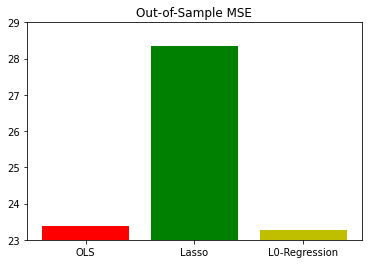

In [ ]:
# 加载数据并分割为训练集(80%)和测试集(20%)
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20,
                                                random_state=10101)

# 使用所有特征的OLS回归
lr = linear_model.LinearRegression()
lr.fit(Xtrain, ytrain)
# 具有交叉验证惩罚项(lambda)的Lasso
lasso = linear_model.LassoCV(cv=5)
lasso.fit(Xtrain, ytrain)
# 通过交叉验证选择最佳特征子集的L0回归
intercept, beta = L0_regression(Xtrain, ytrain, seed=10101)

# 使用条形图比较它们的性能
performance = []
performance.append(mse(ytest, lr.predict(Xtest)))
performance.append(mse(ytest, lasso.predict(Xtest)))
performance.append(mse(ytest, np.dot(Xtest, beta) + intercept))
plot_bar_chart(performance)

注意 Lasso 表现不佳，这是因为我们没有将特征标准化为相同的单位（均值为零，方差为一）。与 OLS 和 L0 回归不同，Lasso 不具有尺度不变性，因为其预算约束基于 L1 范数。请记住，$\beta_l$ 被解释为特征 $l$ 每单位变化对响应变量的影响。由于 L1 范数取绝对值之和，$\beta_l$ 消耗多少预算取决于与之相关的特征的测量单位。

这种预处理包含三个步骤，即：

对于每个特征 $x_l$：
1. 计算其样本均值 $\mu_l$ 和样本标准差 $\sigma_l$。
2. 通过从 $x_l$ 中减去 $\mu_l$ 进行中心化。
3. 通过将得到的差除以 $\sigma_l$ 进行缩放。

为了报告应用标准化后 Lasso 的性能，我们需要通过交叉验证对 L1 范数惩罚进行超参数调优。不幸的是，我们不能使用 `LassoCV` 模型类。这是因为它不支持标准化，而且事先对整个数据集进行标准化会污染折叠数据。为了防止这种情况发生，我们将进行如下随机搜索：

In [ ]:
np.random.seed(10101)
num_tries = 500
best_alpha = None
best_score = -np.inf
for i in range(num_tries):
    # 在区间[0.001, 1000]内对alpha进行对数线性搜索
    exponent = np.random.uniform(-3, 3)
    alpha = np.power(10, exponent)
    pipeline = make_pipeline(StandardScaler(), linear_model.Lasso(alpha=alpha))
    scores = cross_val_score(pipeline, Xtrain, ytrain, cv=5, scoring='neg_mean_squared_error')
    avg_score = np.mean(scores)
    if avg_score > best_score:
        best_score = avg_score
        best_alpha = alpha

让我们现在比较在特征预处理后各模型的性能。请注意，我们自定义的函数`L0-regression`确实支持特征标准化：

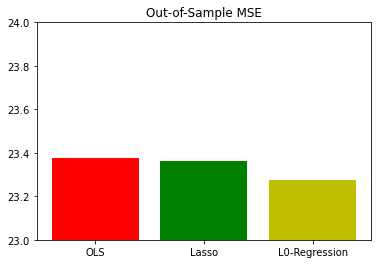

In [ ]:
# 标准化特征使其具有0均值和1的样本方差
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain_std = scaler.transform(Xtrain)
Xtest_std = scaler.transform(Xtest)

# 使用所有特征的OLS回归
lr = linear_model.LinearRegression()
lr.fit(Xtrain_std, ytrain)

# 具有交叉验证惩罚项(lambda)的Lasso
lasso = linear_model.Lasso(alpha=best_alpha)
lasso.fit(Xtrain_std, ytrain)
# 通过交叉验证选择最佳特征子集的L0回归
intercept, beta = L0_regression(Xtrain, ytrain, standardize=True, seed=10101)

# 使用条形图比较它们的性能
performance = []
performance.append(mse(ytest, lr.predict(Xtest_std)))
performance.append(mse(ytest, lasso.predict(Xtest_std)))
performance.append(mse(ytest, np.dot(Xtest_std, beta) + intercept))
plot_bar_chart(performance)

正如预期的那样，Lasso比OLS表现得更好(尽管差异很小)。这是因为当预算 $s$ 足够大时(或者说当 $\lambda$ 足够小时)，Lasso可以恢复 $\beta_{OLS}$ 估计。另一方面，它略逊于L0回归，主要是因为通过收缩 $\beta$ 我们给估计增加了偏差。此外，观察到L0回归使用最少的特征数量实现了最佳性能。这很方便，因为它导致了一个更容易解释的模型。

In [8]:
ols_features = np.sum(np.abs(lr.coef_) >= 1e-8)
lasso_features = np.sum(np.abs(lasso.coef_) >= 1e-8)
l0_features = np.sum(np.abs(beta) >= 1e-8)
print("OLS regression kept {0} features.".format(ols_features))
print("The Lasso kept {0} features.".format(lasso_features))
print("L0-Regression kept {0} features.".format(l0_features))

OLS regression kept 13 features.
The Lasso kept 12 features.
L0-Regression kept 11 features.


### 最终模型

前面的分析表明L0回归建议的模型是最佳候选。结果方程如下：

\begin{equation}
\text{medv} = 22.56-1.02\text{crim}+1.46\text{zn}+0.49\text{chas}-1.93\text{nox}+2.53\text{rm}
\end{equation}

\begin{equation}
-3.48\text{dis}+2.65\text{rad}-2.22\text{tax}-1.87\text{ptratio}+1.00\text{b}-3.69\text{lstat}
\end{equation}

**注意：** 可以通过`scaler.mean_`和`scaler.var_`分别访问标准化步骤中使用的均值和方差向量。

由于我们标准化了数据，截距代表了一个在所有特征上都取平均值的房屋的估计中值(以千美元计)。同样，我们可以解释 $\beta_1=-1.02$ 为：在其他条件相同的情况下，当人均犯罪率从平均值增加一个标准差时房屋价值的降低量(对其他特征可以做类似解释)。最后，如果分析的主要目的是解释响应变量的变异性，11个特征可能太多了。不过，请记住，人们总是可以将活动特征的数量设置为一个更容易管理的数字以便于解释，尽管可能会以牺牲预测能力为代价。

---
## 结论

我们已经展示了如何使用数学规划来对线性回归问题进行特征选择。事实上，它是Lasso的一个很好的替代方案，因为L0回归具有尺度不变性，并且不会给权重估计增加偏差。此外，这种方法易于指定额外的线性约束(Bertsimas, 2015)，例如：

- 在特征之间执行组稀疏性。
- 限制成对多重共线性。
- 限制全局多重共线性。
- 考虑固定集合的非线性变换。

然而，对这个结果要谨慎对待，因为"统计学中没有免费的午餐"。也就是说，没有一种算法在所有可能的数据集上都优于其他算法。最终，一个优秀的数据科学家在分析数据集时应该考虑多种学习算法。

---
## 参考文献

1. Bertsimas, D., & King, A. (2015). OR forum—An algorithmic approach to linear regression. Operations Research, 64(1), 2-16。
2. Bertsimas, D., King, A., & Mazumder, R. (2016). Best subset selection via a modern optimization lens. The annals of statistics, 44(2), 813-852。
3. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer。
4. The Boston housing dataset (1996, October 10). Retrieved from https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

Copyright © 2020 Gurobi Optimization, LLC